# Visualizing Unit Spikes

In our files, the data contains a *spike train* array for each putative neuron. These are arrays of timestamps that a neuron spikes. Since neurons spike different numbers of times and during different times, it would be difficult to analyze many neurons together with the data in this form. One way to solve this is to make a 3-Dimensional *spike matrix*. This is a 3D array with the dimensions `neurons`, `time`, and `trials`. The spike matrix consists of time bins which contain the count of spikes at each time, for each neuron, and for each trial. The spike matrix can be slices or averaged to produce useful 2D plots, or can be plugged in to more complex analysis. One application of this can be seen in [Statistically Testing Spike Responses to Stimulus](../first-order/test_spike_responses.ipynb).

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy.io import savemat

%matplotlib inline

### Downloading Ecephys File
Change the values below to download the file you’re interested in. In this example, we the `Units` table of an Ecephys file from The Allen Institute's **Visual Coding - Neuropixels** dataset, so you'll have to choose one with the same kind of data. Set `dandiset_id` and `dandi_filepath` to correspond to the dandiset id and filepath of the file you want. If you’re accessing an embargoed dataset, set `dandi_api_key` to your DANDI API key.

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-717038285/sub-717038285_ses-732592105.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

PATH                            SIZE   DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-717038285_ses-732592105.nwb 2.9 GB 2.9 GB           100%    ok    done                   
Summary:                        2.9 GB 2.9 GB                         1 done                 
                                       100.00%                                               
Downloaded file to ./sub-717038285_ses-732592105.nwb
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Getting Units Data and Stimulus Data
Below, the `Units` table is retrieved from the file. It contains many metrics for every putative neuronal unit, printed below. For the analysis in this notebook, we are only interested in the `spike_times` attribute. This is an array of timestamps at which a spike is measured for that unit.

In [5]:
units = nwb.units
units.colnames

('velocity_below',
 'amplitude_cutoff',
 'repolarization_slope',
 'snr',
 'firing_rate',
 'waveform_duration',
 'presence_ratio',
 'isi_violations',
 'cumulative_drift',
 'spread',
 'max_drift',
 'PT_ratio',
 'nn_hit_rate',
 'quality',
 'recovery_slope',
 'velocity_above',
 'isolation_distance',
 'l_ratio',
 'peak_channel_id',
 'd_prime',
 'cluster_id',
 'amplitude',
 'waveform_halfwidth',
 'local_index',
 'silhouette_score',
 'nn_miss_rate',
 'spike_times',
 'spike_amplitudes',
 'waveform_mean')

In [6]:
units[:10]

,velocity_below,amplitude_cutoff,repolarization_slope,snr,firing_rate,waveform_duration,presence_ratio,isi_violations,cumulative_drift,spread,...,d_prime,cluster_id,amplitude,waveform_halfwidth,local_index,silhouette_score,nn_miss_rate,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
915957951,-0.343384,0.000886,0.880810,4.800479,2.035908,0.686767,0.98,0.000000,53.49,50.0,...,6.214486,323,234.454545,0.137353,314,0.229600,0.000102,"[58.4338983925338, 68.84436108646727, 69.12766...","[0.00035119779048895465, 0.0003151291869021440...","[[0.0, 0.2250300000000216, 2.9977350000000555,..."
915957946,0.000000,0.000217,0.400703,3.429461,5.738931,0.714238,0.99,0.009670,123.55,50.0,...,6.316538,322,138.920730,0.151089,313,0.158374,0.000906,"[1.021669806312146, 1.1772369117243047, 2.5084...","[0.00016757406732947436, 0.0001720397921770987...","[[0.0, -3.2106749999999806, 3.150420000000011,..."
915957691,-1.103733,0.014154,0.426480,1.919786,2.008079,0.796650,0.99,2.705249,290.95,100.0,...,3.662792,275,147.761055,0.206030,268,0.158752,0.001013,"[0.6530354333202749, 3.2586094484803794, 3.264...","[7.60907503923193e-05, 7.957109416173626e-05, ...","[[0.0, -11.971440000000083, -12.44139000000006..."
915957685,-0.956569,0.000230,0.842665,4.186323,4.709665,0.837856,0.99,0.005385,53.80,90.0,...,5.161656,274,260.690625,0.192295,267,0.234811,0.000138,"[1.2490037807948806, 1.2540371283237506, 1.831...","[0.000266164371359917, 0.0002605838430779542, ...","[[0.0, -5.997810000000001, 5.6064450000000186,..."
915956513,0.343384,0.500000,0.562422,3.457604,2.181748,0.645561,0.99,0.209098,139.54,60.0,...,2.918675,43,221.177190,0.247236,43,0.057446,0.003356,"[3.2777428357755536, 11.522366088064498, 12.26...","[0.000144906487588058, 0.00010868803407731714,...","[[0.0, 0.0228149999999836, 2.534804999999988, ..."
915956508,1.030151,0.000004,0.958932,5.408729,6.252715,0.494472,0.99,0.001018,30.54,50.0,...,6.895246,42,322.610340,0.192295,42,0.212086,0.002584,"[14.719841772563301, 22.41733014843588, 30.700...","[0.0002151604191262871, 0.00020362049040077184...","[[0.0, 7.416434999999929, 3.2403149999999847, ..."
915956502,-1.030151,0.001222,0.513393,3.237491,16.870943,0.563149,0.99,0.031472,83.51,40.0,...,4.833891,41,187.746780,0.206030,41,0.218050,0.001938,"[1.4603043767253872, 1.4698044035182873, 1.481...","[0.00015597232901272, 0.0002357881951492309, 0...","[[0.0, -1.0518299999999812, -1.572479999999974..."
915957820,0.423506,0.500000,0.451907,3.245378,0.008816,0.192295,0.26,0.000000,0.00,90.0,...,2.035774,300,113.818916,0.109883,292,NaN,0.000000,"[461.1188340837827, 4209.908773452706, 4513.18...","[6.916100951089473e-05, 0.00010573897883329469...","[[0.0, -7.005903614457829, -4.6729518072289125..."
915957814,-0.686767,0.219911,0.377458,2.882758,2.044300,0.274707,0.91,0.152423,211.72,20.0,...,6.940011,299,90.401025,0.109883,291,0.063454,0.000170,"[403.78390571557065, 540.1631903457029, 1001.0...","[8.160101108265708e-05, 8.231111987309405e-05,...","[[0.0, -2.198040000000006, 8.860604999999943, ..."


In [7]:
units_spike_times = units["spike_times"]
print(units_spike_times.shape)

(3076,)


### Selecting Stimulus Times
Different types of stimulus require different kinds of inclusion criteria. Since the available stimulus tables vary significantly depending which NWB file and which experimental session you're analyzing, you'll may have to adjust some values below for your analysis. First, select which stimulus table you want by changing the key used below in `nwb.intervals`. The list of stimulus table names is printed below to inform this choice. Additionally, you'll have to modify the function `stim_select` to select the stimulus times you want to use. In this example, the stimulus type is the presentation of [Gabor patches](https://en.wikipedia.org/wiki/Gabor_filter), and the stimulus times are chosen where a Gabor patch is shown at x and y coordinates 40, 40. 

In [8]:
stimulus_names = list(nwb.intervals.keys())
print(stimulus_names)

['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'invalid_times', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations']


In [9]:
stim_table = nwb.intervals["gabors_presentations"]
print(stim_table.colnames)
stim_table[:10]

('start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'temporal_frequency', 'x_position', 'y_position', 'color', 'mask', 'opacity', 'phase', 'size', 'units', 'stimulus_index', 'orientation', 'spatial_frequency', 'contrast', 'tags', 'timeseries')


,start_time,stop_time,stimulus_name,stimulus_block,temporal_frequency,x_position,y_position,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,,,,
0,81.645874,81.879397,gabors,0.0,4.0,-30.0,-20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,45.0,0.08,0.8,[stimulus_time_interval],"[(1, 1, timestamps pynwb.base.TimeSeries at 0x..."
1,81.879397,82.129600,gabors,0.0,4.0,20.0,-10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(2, 1, timestamps pynwb.base.TimeSeries at 0x..."
2,82.129600,82.379803,gabors,0.0,4.0,40.0,30.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(3, 1, timestamps pynwb.base.TimeSeries at 0x..."
3,82.379803,82.630006,gabors,0.0,4.0,40.0,-40.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,45.0,0.08,0.8,[stimulus_time_interval],"[(4, 1, timestamps pynwb.base.TimeSeries at 0x..."
4,82.630006,82.880215,gabors,0.0,4.0,-30.0,10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,45.0,0.08,0.8,[stimulus_time_interval],"[(5, 1, timestamps pynwb.base.TimeSeries at 0x..."
5,82.880215,83.130425,gabors,0.0,4.0,30.0,10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,45.0,0.08,0.8,[stimulus_time_interval],"[(6, 1, timestamps pynwb.base.TimeSeries at 0x..."
6,83.130425,83.380635,gabors,0.0,4.0,-40.0,-10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(7, 1, timestamps pynwb.base.TimeSeries at 0x..."
7,83.380635,83.630844,gabors,0.0,4.0,-10.0,20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(8, 1, timestamps pynwb.base.TimeSeries at 0x..."
8,83.630844,83.881050,gabors,0.0,4.0,10.0,30.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(9, 1, timestamps pynwb.base.TimeSeries at 0x..."


In [10]:
### select start times from table that fit certain criteria here

stim_select = lambda row: True
stim_select = lambda row: float(row.x_position) == 40 and float(row.y_position) == 40
stim_times = [float(stim_table[i].start_time) for i in range(len(stim_table)) if stim_select(stim_table[i])]
print(len(stim_times))

45


### Getting Unit Spike Response Counts
With stimulus times selected for each trial, we can generate a *spike matrix* to perform our analysis on. The spike matrix will have dimensions `Units`, `Time`, and `Trials`. You may set `time_resolution` to be the duration, in seconds, of each time bin in the matrix. Additionally, `window_start_time`, and `window_end_time` can be set to the time, in seconds, relative to the onset of the stimulus at time 0. Finally, the stimulus matrix will also be averaged across trials to get the average spike counts over time for each unit, called `mean_spike_counts`.

In [11]:
# bin size for counting spikes
time_resolution = 0.005

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
window_start_time = -0.25
window_end_time = 0.75

In [12]:
# time bins used
n_bins = int((window_end_time - window_start_time) / time_resolution)
bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

# useful throughout analysis
n_units = len(units_spike_times)
n_trials = len(stim_times)

# calculate baseline and stimulus interval indices for use later
stimulus_onset_idx = int(-bin_edges[0] / time_resolution)

In [13]:
# 3D spike matrix to be populated with spike counts
spike_matrix = np.zeros((n_units, len(bin_edges), n_trials))

# populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
for unit_idx in range(n_units):
    spike_times = units_spike_times[unit_idx]

    for stim_idx, stim_time in enumerate(stim_times):
        # get spike times that fall within the bin's time range relative to the stim time        
        first_bin_time = stim_time + bin_edges[0]
        last_bin_time = stim_time + bin_edges[-1]
        first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
        spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

        # convert spike times into relative time bin indices
        bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
        
        # mark that there is a spike at these bin times for this unit on this stim trial
        for bin_idx in bin_indices:
            spike_matrix[unit_idx, bin_idx, stim_idx] += 1

spike_matrix.shape

(3076, 200, 45)

### Spike Plots From Spike Matrix
To demonstrate visually how it can be used, the plots below show different slices of the spike matrix. The first plot, *Unit Spikes Across Trials* shows the spiking behavior of one Unit across all trials. Set `unit` below to change which unit you'd like be shown. Following this is the *Unitwise Spike Plot*, which shows the spikes of all Units during the time window of one trial. Finally, the *Average Unitwise Spike Plot* shows the spikes of all units averaged across all trials. By themselves, these plots don't tell much. Useful versions of similar plots are depicted in notebooks such as [Identifying Optotagged Units](../first-order/optotagging.ipynb), and [Statistically Testing Spike Responses to Stimulus](../first-order/test_spike_responses.ipynb)

#### Unit Spikes Across Trials

In [14]:
unit = 0

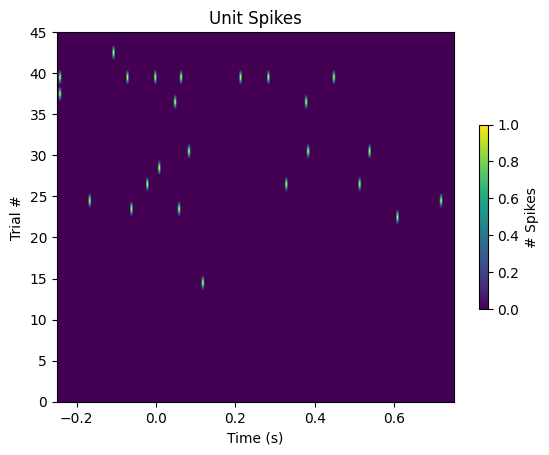

In [15]:
fig, ax = plt.subplots()

ax.set_title("Unit Spikes")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Trial #")

img = ax.imshow(spike_matrix[unit,:,:].transpose(), extent=[window_start_time,window_end_time,0,n_trials], aspect="auto")
cbar = fig.colorbar(img, shrink=0.5)
cbar.set_label("# Spikes")

#### Unitwise Spike Plot

In [16]:
trial = 0

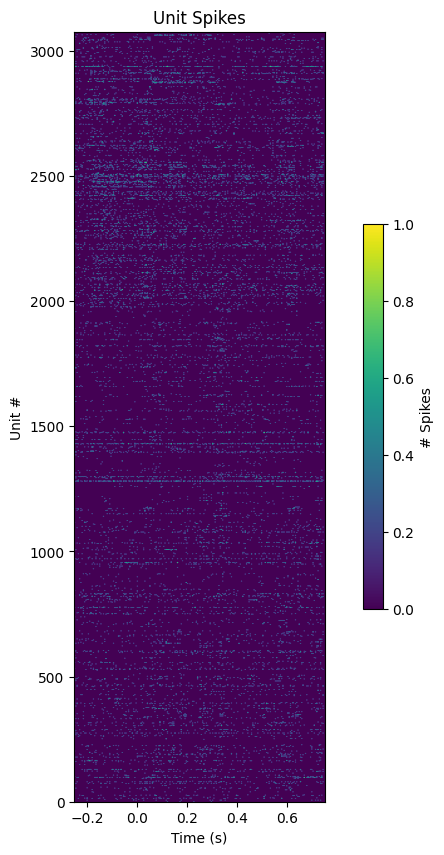

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_title("Unit Spikes")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Unit #")

img = ax.imshow(spike_matrix[:,:,trial], extent=[window_start_time,window_end_time,0,n_units], aspect=0.001, vmin=0, vmax=1)
cbar = fig.colorbar(img, shrink=0.5)
cbar.set_label("# Spikes")

#### Average Unitwise Spike Plot

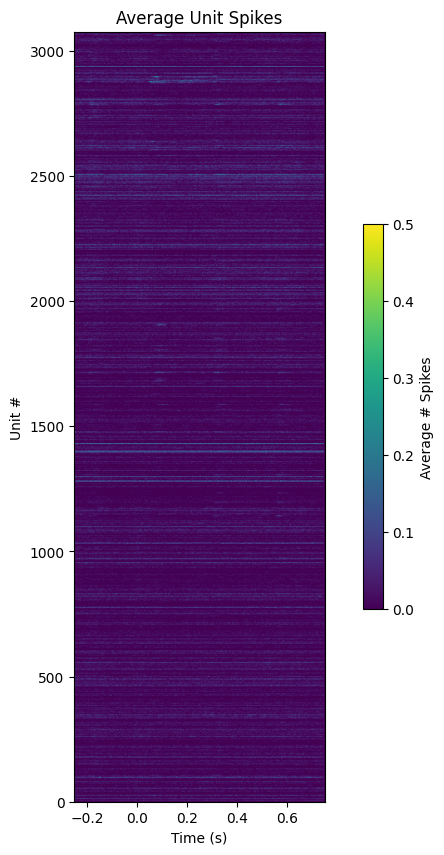

In [18]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_title("Average Unit Spikes")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Unit #")

img = ax.imshow(np.average(spike_matrix, axis=2), extent=[window_start_time,window_end_time,0,n_units], aspect=0.001, vmin=0, vmax=0.5)
cbar = fig.colorbar(img, shrink=0.5)
cbar.set_label("Average # Spikes")

### Saving Spike Matrix
The spike matrix can be saved/exported for use in other programs using several methods. Below, numpy's `save` method is used to save the matrix in the `npy` format for use in other Python programs. Scipy's `savemat` function saves the matrix in a format usable for **Matlab**.

In [19]:
np.save("spike_matrix.npy", spike_matrix)

In [20]:
savemat("spike_matrix.mat", dict(spike_matrix=spike_matrix))